In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from owlrl import DeductiveClosure, OWLRL_Semantics
from rdflib import *
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph


def plot_graph(graph, axes=None, show=True):
    ax = axes or plt.gca()
    netgraph = rdflib_to_networkx_multidigraph(graph)
    for layer, nodes in enumerate(nx.topological_generations(netgraph)):
        for node in nodes:
            netgraph.nodes[node]["layer"] = layer
    pos = nx.multipartite_layout(netgraph, subset_key="layer")
    edge_labels = nx.get_edge_attributes(netgraph, 'r')
    nx.draw_networkx(netgraph, pos=pos, with_labels=True, ax=ax)
    nx.draw_networkx_edge_labels(netgraph, pos=pos, edge_labels=edge_labels, ax=ax)
    if show:
        plt.show()

In [10]:
ontology = Graph()
ontology.parse(r'../ontologies/ontology_full.ttl')
ontology.parse(r'../ontologies/BIGOWLData.owl')
ontology.parse(r'../ontologies/BIGOWLProblems.owl')
ontology.parse(r'../ontologies/BIGOWLAlgorithms.owl')
ontology.parse(r'../ontologies/BIGOWLWorkflows.owl')
ontology.parse(r'../dataset_annotator/penguins_annotated.ttl')
ontology.parse(r'../dataset_annotator/titanic_annotated.ttl')
ontology.parse(r'../ontology_populator/restrictions.ttl')
ontology.parse(r'../ontology_populator/components.ttl')
DeductiveClosure(OWLRL_Semantics).expand(ontology)

bigowl_data = Namespace('https://w3id.org/BIGOWLData/')
bigowl_algorithms = Namespace('https://w3id.org/BIGOWLAlgorithms/')
bigowl_problems = Namespace('https://w3id.org/BIGOWLProblems/')
bigowl_workflows = Namespace('https://w3id.org/BIGOWLWorkflows/')
do = Namespace('https://diviloper.dev/ontology#')
abox = Namespace('https://diviloper.dev/ABox#')
dmop = Namespace('http://www.e-lico.eu/ontologies/dmo/DMOP/DMOP.owl#')

In [3]:
ug = Graph()
ug.add((abox.ClusteringIntent1, RDF.type, do.UserIntent))
ug.add((abox.ClusteringIntent1, do.tacklesProblem, do.Clustering))
ug.add((abox.ClusteringIntent1, do.overData, abox.term('penguins.csv')))

ug2 = Graph()
ug2.add((abox.ClusteringIntent2, RDF.type, do.UserIntent))
ug2.add((abox.ClusteringIntent2, do.tacklesProblem, do.Describe))
ug2.add((abox.ClusteringIntent2, do.overData, abox.term('penguins.csv')))
parameter_value = BNode()
ug2.add((abox.ClusteringIntent2, do.specifiesParameterValue, parameter_value))
ug2.add((parameter_value, do.forParameterName, Literal('Number of Clusters')))
ug2.add((parameter_value, do.withValue, Literal(3, datatype=XSD.integer)))

ug3 = Graph()
ug3.add((abox.ClusteringIntent3, RDF.type, do.UserIntent))
ug3.add((abox.ClusteringIntent3, do.tacklesProblem, do.Describe))
ug3.add((abox.ClusteringIntent3, do.overData, abox.term('penguins.csv')))
parameter_value = BNode()
ug3.add((abox.ClusteringIntent3, do.specifiesParameterValue, parameter_value))
ug3.add((parameter_value, do.forParameterName, Literal('epsilon')))
ug3.add((parameter_value, do.withValue, Literal(0.7)))

<Graph identifier=N5fe7cdb50bce4cba9461c29a6707b67e (<class 'rdflib.graph.Graph'>)>

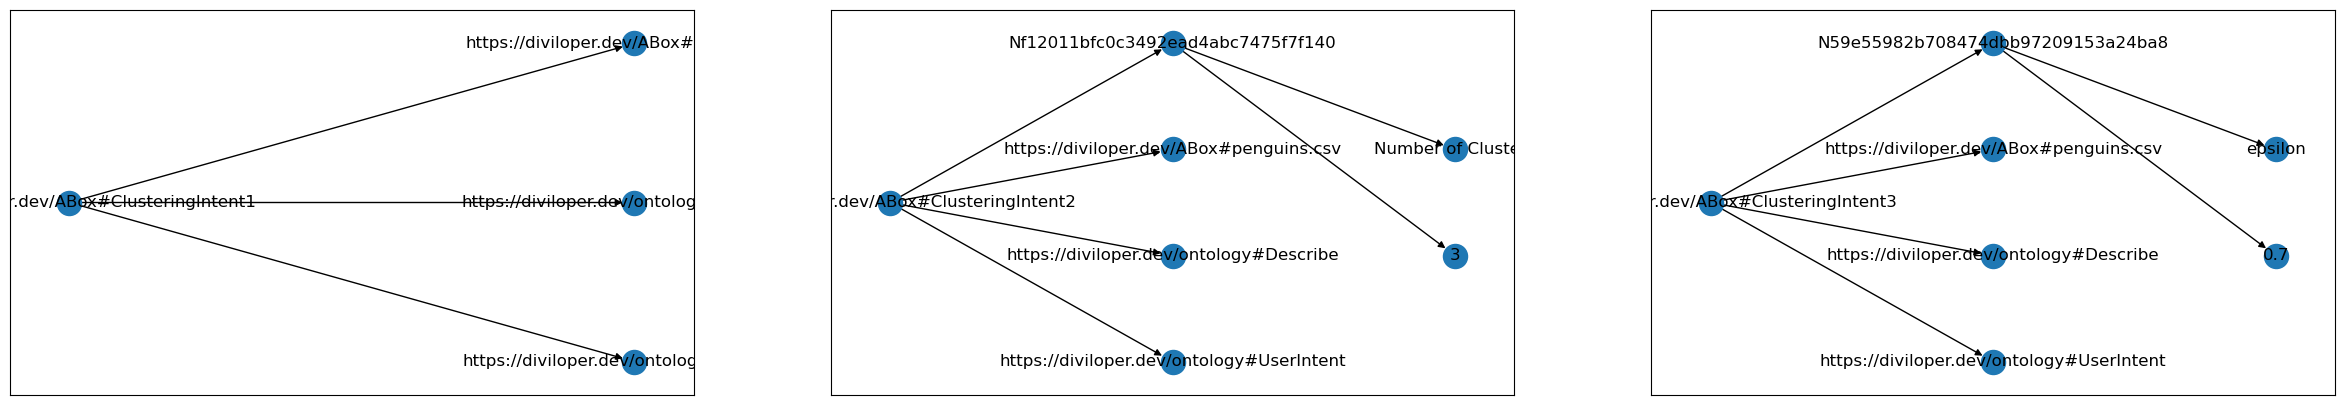

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
plot_graph(ug, axes=axs[0], show=False)
plot_graph(ug2, axes=axs[1], show=False)
plot_graph(ug3, axes=axs[2], show=False)
plt.show()

In [5]:
# Input: graph + user intent iri
intent = ug
user_intent = abox.ClusteringIntent1
workflow_name = 'Clustering1'

In [6]:
def get_intent_dataset_problem(intent_graph, intent_iri):
    result = intent_graph.query(f"""
    PREFIX do: <{do}>
    SELECT ?dataset ?problem
    WHERE {{
        <{intent_iri}> a do:UserIntent .
        <{intent_iri}> do:overData ?dataset .
        <{intent_iri}> do:tacklesProblem ?problem .
    }}
""").bindings[0]
    return result['dataset'], result['problem']


dataset, problem = get_intent_dataset_problem(intent, user_intent)
print(dataset)
print(problem)

https://diviloper.dev/ABox#penguins.csv
https://diviloper.dev/ontology#Clustering


In [7]:
def get_intent_params(intent_graph, intent_iri):
    result = intent_graph.query(f"""
    PREFIX do: <{do}>
    SELECT ?param_name ?value
    WHERE {{
        <{intent_iri}> a do:UserIntent .
        <{intent_iri}> do:specifiesParameterValue ?param_value .
        ?param_value do:forParameterName ?param_name .
        ?param_value do:withValue ?value .
    }}
""").bindings
    return result


intent_params = get_intent_params(intent, user_intent)
print(intent_params)

[]


In [8]:
def get_loaders(ontology_graph, dataset_iri):
    result = ontology_graph.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_d: <{bigowl_data}>
    SELECT ?loader ?path
    WHERE {{
        <{dataset_iri}> do:fileFormat ?format ;
                    big_d:path ?path .
        ?loader a big_w:DataIngestion ;
                do:fileFormat ?format .
    }}
""").bindings
    return result


loaders = get_loaders(ontology, dataset)
dataset_loader = loaders[0]
dataset_loader

{rdflib.term.Variable('loader'): rdflib.term.URIRef('https://diviloper.dev/ontology#Import_CSV'), rdflib.term.Variable('path'): rdflib.term.Literal('C:\\Users\\Victor\\Development\\BDMA\\Thesis\\Ontology\\dataset_annotator\\penguins.csv')}

In [9]:
def get_components(ontology_graph, problem_iri, intent_parameters):
    intent_params_match = [f'            big_w:hasParameter ?param_{i} ;' for i in range(len(intent_parameters))]
    intent_params_filters = [f"""
        FILTER regex(?parameterLabel, "{param['param_name']}", "i")
        {{
            ?param_{i} rdfs:label ?parameterLabel .
        }} UNION {{
            ?param_{i} big_w:hasName ?parameterLabel .
        }}""" for i, param in enumerate(intent_parameters)]

    result = ontology_graph.query(f"""
    PREFIX do: <{do}>
    PREFIX big_w: <{bigowl_workflows}>
    PREFIX big_p: <{bigowl_problems}>
    PREFIX big_a: <{bigowl_algorithms}>
    SELECT ?component
    WHERE {{
        ?component a big_w:Component ;
{''.join(intent_params_match)}
            big_w:hasAlgorithm ?algorithm .
        ?algorithm big_a:solves ?p .
        ?p do:subProblemOf* <{problem_iri}> .
{''.join(intent_params_filters)}
    }}
""").bindings

    return result


components = get_components(ontology, problem, intent_params)
components

[{rdflib.term.Variable('component'): rdflib.term.URIRef('https://diviloper.dev/ontology#KMeansComponent')},
 {rdflib.term.Variable('component'): rdflib.term.URIRef('https://diviloper.dev/ontology#MixtureGaussianComponent')},
 {rdflib.term.Variable('component'): rdflib.term.URIRef('https://diviloper.dev/ontology#DBSCANComponent')}]

In [ ]:
def get_component_input_shapes(ontology_graph, components):
    result = [
        ontology_graph.query(f"""
        PREFIX big_w: <{bigowl_workflows}>
        SELECT ?shape
        WHERE {{
            <%s> big_w:hasInputShape ?shape .
        }}
    """ % component['component']).bindings[0]['shape']
        for component in components]
    return result

In [16]:
def get_component_params(ontology_graph, components, intent_parameters):
    param_query = f"""
    PREFIX big_w: <{bigowl_workflows}>
    SELECT ?param ?param_name ?value
    WHERE {{
        <%s> big_w:hasParameter ?param .
        ?param big_w:hasName ?param_name .
        OPTIONAL {{
            ?param big_w:hasDefaultValue ?value .
        }}
    }}"""
    result = [
        [{str(k): v for k, v in x.items()} for x in ontology_graph.query(param_query % component['component']).bindings]
        for component in components]

    for intent_param in intent_parameters:
        for param in result:
            for p in param:
                if p['param_name'].lower() == intent_param['param_name'].lower():
                    p['value'] = intent_param['value']

    return result


params = get_component_params(ontology, components, intent_params)
params

[[{'param': rdflib.term.URIRef('https://diviloper.dev/ontology#KMeans:NumberOfClusters'),
   'param_name': rdflib.term.Literal('n_clusters')}],
 [{'param': rdflib.term.URIRef('https://diviloper.dev/ontology#Epsilon'),
   'param_name': rdflib.term.Literal('Epsilon'),
   'value': rdflib.term.Literal('0.5', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double'))},
  {'param': rdflib.term.URIRef('https://diviloper.dev/ontology#minPoints'),
   'param_name': rdflib.term.Literal('Minimum Points'),
   'value': rdflib.term.Literal('5', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer'))}],
 [{'param': rdflib.term.URIRef('https://diviloper.dev/ontology#MixtureGaussian:NumberOfClusters'),
   'param_name': rdflib.term.Literal('n_clusters')}]]

In [17]:
def add_task(graph, pipeline, task_name, component, parameters, order, previous_task=None):
    task = abox.term(task_name)
    graph.add((pipeline, bigowl_workflows.hasTask, task))
    graph.add((task, RDF.type, bigowl_workflows.Task))
    graph.add((task, bigowl_workflows.hasComponent, component))
    graph.add((task, bigowl_workflows.order, Literal(order)))
    for param in parameters:
        param_value = BNode()
        graph.add((task, do.hasParameterValue, param_value))
        graph.add((param_value, do.forParameter, param['param']))
        if 'value' in param:
            graph.add((param_value, do.hasValue, param['value']))
        else:
            graph.add((param_value, do.hasValue, Literal('REQUIRES USER INPUT')))
    if previous_task:
        graph.add((previous_task, bigowl_workflows.connectedTo, task))
    return task

In [21]:
workflow_graphs = [Graph() for _ in range(len(components))]
for i, workflow_graph in enumerate(workflow_graphs):
    wf_name = f'wf/{workflow_name}/{i}'
    workflow = abox.term(wf_name)
    workflow_graph.add((workflow, RDF.type, bigowl_workflows.Workflow))

    load_task = add_task(workflow_graph, workflow, f'{wf_name}/1', dataset_loader['loader'],
                         [{'param': do.URL_Param, 'value': dataset_loader['path']}], 1)
    component_task = add_task(workflow_graph, workflow, f'{wf_name}/2', components[i]['component'], params[i], 2,
                              load_task)

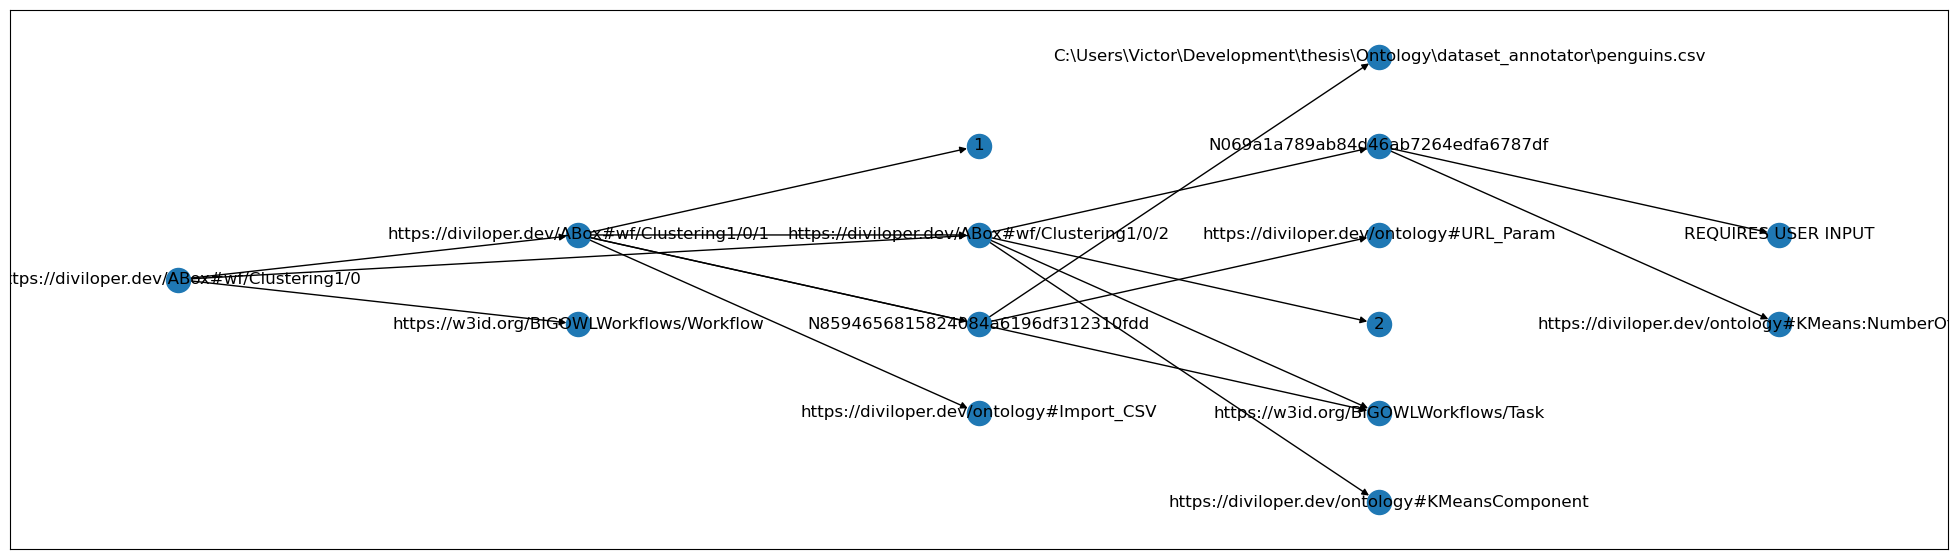

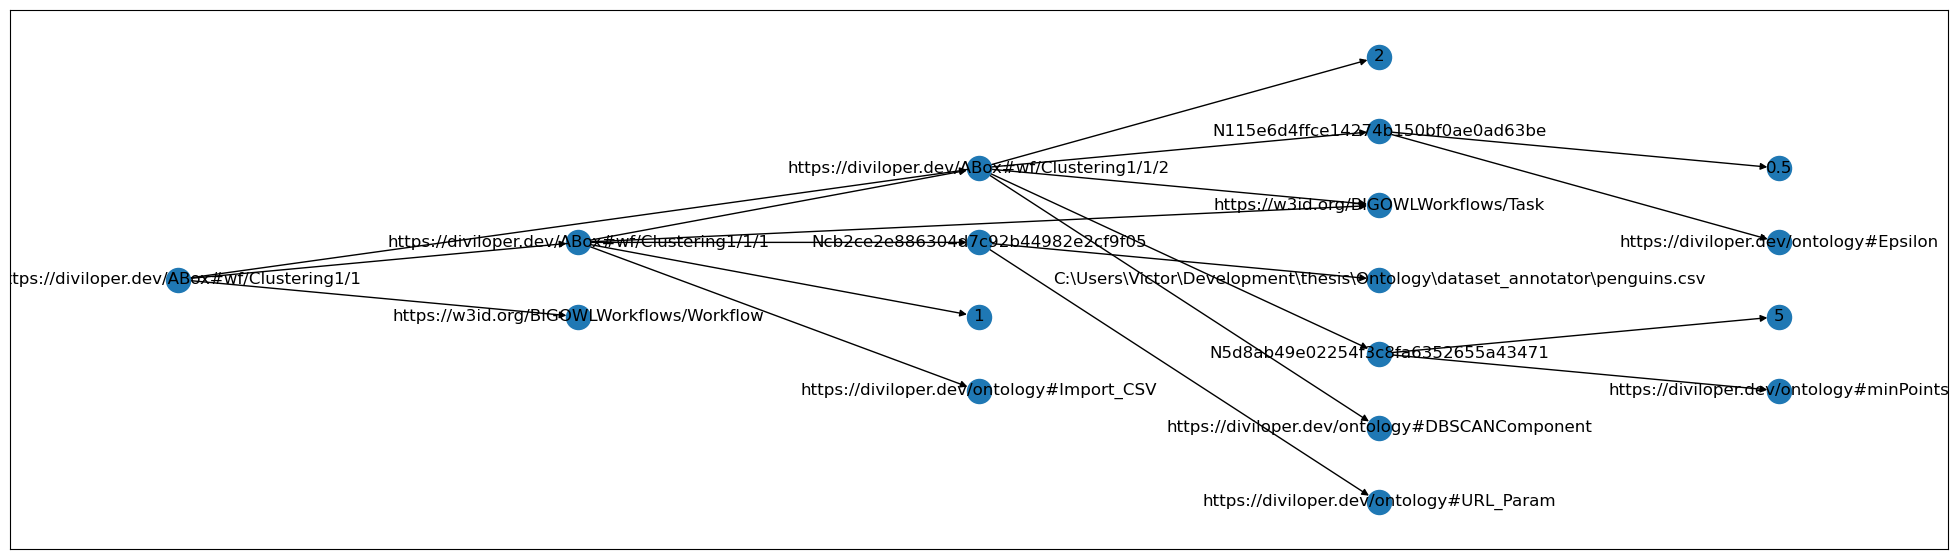

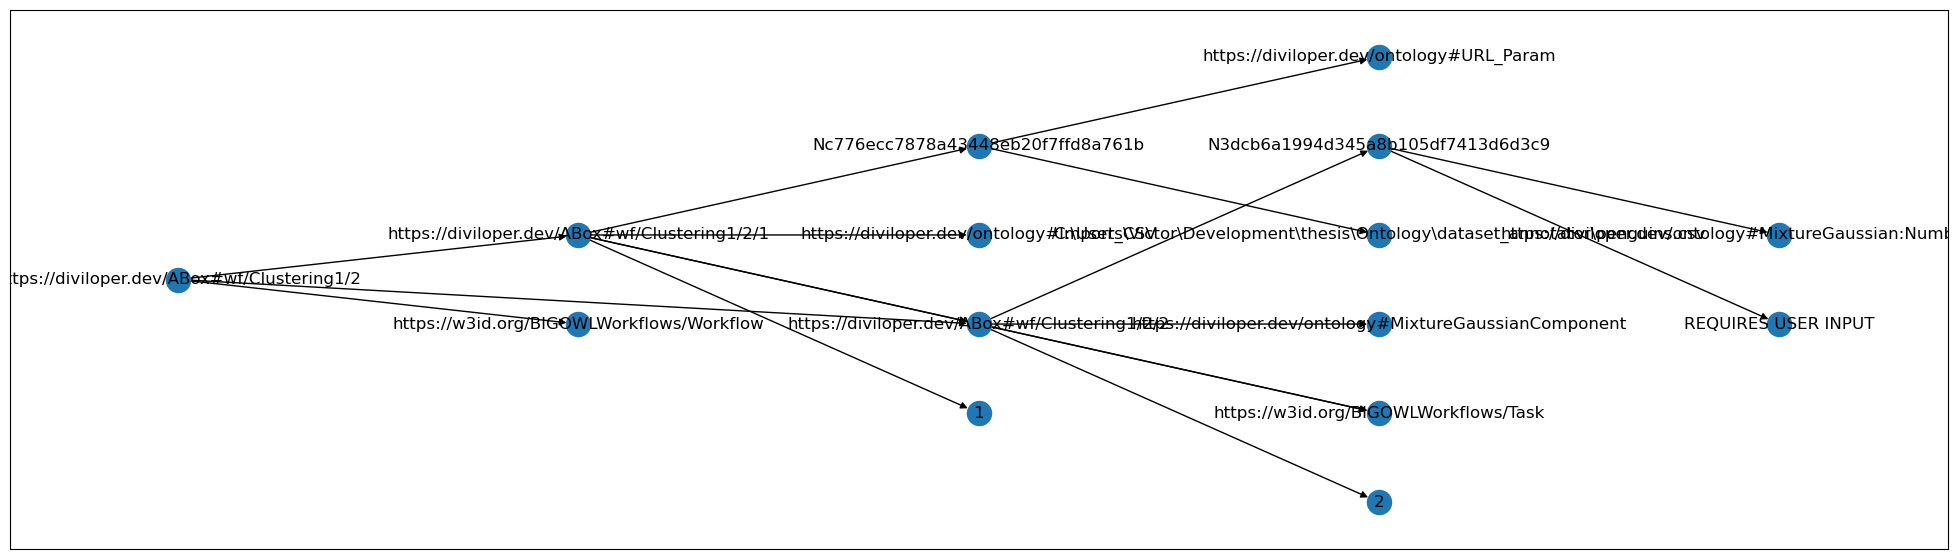

In [22]:
for wf in workflow_graphs:
    plt.figure(figsize=(25, 7))
    plot_graph(wf)

In [23]:
for i, workflow_graph in enumerate(workflow_graphs):
    workflow_graph.serialize(f'./{workflow_name}_{i}.ttl')
intent.serialize(f'./{workflow_name}_user_intent.ttl')

<Graph identifier=Nefc695343b0044039dc0b3fe9cbd1ce3 (<class 'rdflib.graph.Graph'>)>